In [20]:
import crflux.models as pm
import numpy as np
from crflux.models import PrimaryFlux
from MCEq.core import MCEqRun
import matplotlib.pyplot as plt

mceq_run = MCEqRun(
interaction_model='SIBYLL2.3c',
primary_model=(pm.HillasGaisser2012, "H3a"),
theta_deg=0.0
)
e_grid = mceq_run.e_grid
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

muons_base = np.zeros_like(e_grid)
n_base = np.zeros_like(e_grid)

for theta in angles:
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()
    muons_base += (mceq_run.get_solution('total_mu+', mag=0)
                    + mceq_run.get_solution('total_mu-', mag=0))
    n_base += mceq_run.get_solution('n0', mag=0)
n_base /= len(angles)
muons_base /= len(angles)

data = np.vstack((e_grid[:58], muons_base[:58]*1e4, n_base[:58]*1e4)).T
np.savetxt(f'Data/flux_data/H3a.txt', data)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [21]:
class SNHillasGaisser2012(PrimaryFlux):
    def __init__(self, model):

        self.name = 'Mod'
        self.sname = model
        self.t = model[0]*3.154e7
        self.d = model[1]*3.086e18
        self.egfactor = model[2]
        self.egcut = model[3]
        self.enhanced = model[4]
        self.params = {}
        self.SNfrac = {}
        self.rid_cutoff = {}

        mass_comp = [14, 402, 1206, 2814, 5426]
        for mcomp in mass_comp:
            self.params[mcomp] = {}
            self.SNfrac[mcomp] = 0.0

        self.rid_cutoff[1] = 4e6
        self.rid_cutoff[2] = 30e6
        self.rid_cutoff[3] = 2e9

        self.SNfrac[14] = 0.90  # H
        self.SNfrac[402] = 0.08  # He
        self.SNfrac[1206] = 0.01  # CNO
        self.SNfrac[2814] = 0.005  # MgAlSi
        self.SNfrac[5426] = 0.005 # Fe

        self.params[14][1] = (1.*7860, 1.66, 1)  # H
        self.params[402][1] = (1.*3550, 1.58, 2)  # He
        self.params[1206][1] = (1.*2200, 1.63, 6)  # CNO
        self.params[2814][1] = (1.*1430, 1.67, 14)  # MgAlSi
        self.params[5426][1] = (1.*2120, 1.63, 26)  # Fe

        self.params[14][2] = (1*20, 1.4, 1)  # H
        self.params[402][2] = (1*20, 1.4, 2)  # He
        self.params[1206][2] = (1*13.4, 1.4, 6)  # CNO
        self.params[2814][2] = (1*13.4, 1.4, 14)  # MgAlSi
        self.params[5426][2] = (1*13.4, 1.4, 26)  # Fe

        self.params[14][3] = (1*1.7, 1.4, 1)  # H
        self.params[402][3] = (1*1.7, 1.4, 2)  # He
        self.params[1206][3] = (1*1.14, 1.4, 6)  # CNO
        self.params[2814][3] = (1*1.14, 1.4, 14)  # MgAlSi
        self.params[5426][3] = (1*1.14, 1.4, 26)  # Fe

        self.nucleus_ids = list(self.params.keys())

    def nucleus_flux(self, corsika_id, E):
        corsika_id = self._find_nearby_id(corsika_id)

        flux = 0.0
        for i in range(1, 4):
            p = self.params[corsika_id][i]
            flux += p[0] * E ** (-p[1] - 1.0) * \
                np.exp(-E / p[2] / self.rid_cutoff[i])
        
        D0 = 2e28
        Q0 = 4.e52 * self.SNfrac[corsika_id]
        Ecut = 1e6
        D = D0 * (E**(1/3))
        Q = Q0 * (E**-2.2) * np.exp(-E/ self.params[corsika_id][3][2] / Ecut)
        flux += ((Q)/(np.pi**1.5 * np.sqrt(4*D*self.t)**3)  * \
            np.exp(-self.d**2/(4*D*self.t)))* 1e4 * 3e10/ 4*np.pi
        
        
        flux += self.egfactor * self.params[corsika_id][3][0] * E ** (-self.params[corsika_id][3][1] - 1.0) * \
            np.exp(-E / self.params[corsika_id][3][2] / self.egcut)
    

        max_enhancement = 5.
        turn_off_energy = 15.
        steepness = 1.

        if self.enhanced > 0:
            enhancement_factor = self.enhanced*(((max_enhancement - 1) * (1 - 1 / (1 + np.exp(-steepness * (np.log10(E) - np.log10(turn_off_energy))))) + 1))
            flux *= enhancement_factor

        return flux

MCEqRun::set_primary_model(): SNHillasGaisser2012 (2500.0, 100, 0, 4000000000.0, 0)
MCEqRun::set_primary_model(): SNHillasGaisser2012 (7500.0, 100, 0, 4000000000.0, 0)
MCEqRun::set_primary_model(): SNHillasGaisser2012 (12500.0, 100, 0, 4000000000.0, 0)
MCEqRun::set_primary_model(): SNHillasGaisser2012 (17500.0, 100, 0, 4000000000.0, 0)
MCEqRun::set_primary_model(): SNHillasGaisser2012 (22500.0, 100, 0, 4000000000.0, 0)
MCEqRun::set_primary_model(): SNHillasGaisser2012 (27500.0, 100, 0, 4000000000.0, 0)
MCEqRun::set_primary_model(): SNHillasGaisser2012 (32500.0, 100, 0, 4000000000.0, 0)
MCEqRun::set_primary_model(): SNHillasGaisser2012 (37500.0, 100, 0, 4000000000.0, 0)
MCEqRun::set_primary_model(): SNHillasGaisser2012 (42500.0, 100, 0, 4000000000.0, 0)


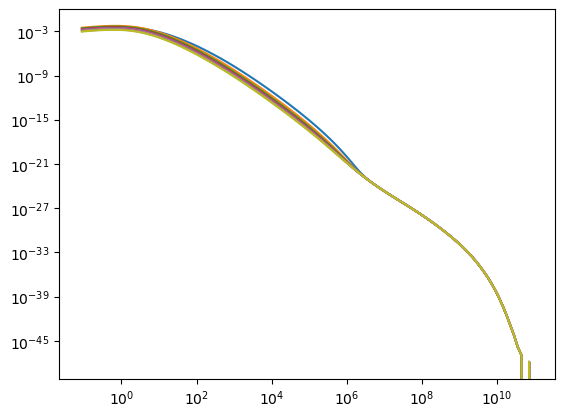

In [29]:
enhance = False
for i, age in enumerate(np.linspace(2.5, 42.5, 9)*1e3):
    mceq_run.set_primary_model(SNHillasGaisser2012, (age, 100, 0, 4e9, 0))
    muons = np.zeros_like(e_grid)
    n0 = np.zeros_like(e_grid)


    for theta in angles:
        mceq_run.set_theta_deg(theta)
        mceq_run.solve()

        muons += (mceq_run.get_solution('total_mu+', mag=0)
                        + mceq_run.get_solution('total_mu-', mag=0))
        n0 += mceq_run.get_solution('n0', mag=0)
    n0 /= len(angles)
    muons /= len(angles)
    plt.loglog(e_grid, muons, label=f'SN@100 pc, {int(age/1000)} kyr')
    data = np.vstack((e_grid[:58], muons[:58]*1e4, n0[:58]*1e4)).T
    np.savetxt(f'Data/flux_data/SN100pc_{int(age/1000)}kyr.txt', data)

if enhance:

    for i, age in enumerate(np.linspace(10, 15, 3)*1e3):
        mceq_run.set_primary_model(SNHillasGaisser2012, (age, 250, 0, 4e9, 1))
        muons = np.zeros_like(e_grid)
        n0 = np.zeros_like(e_grid)


        for theta in angles:
            mceq_run.set_theta_deg(theta)
            mceq_run.solve()

            muons += (mceq_run.get_solution('total_mu+', mag=0)
                            + mceq_run.get_solution('total_mu-', mag=0))
            n0 += mceq_run.get_solution('n0', mag=0)
        n0 /= len(angles)
        muons /= len(angles)
        plt.loglog(e_grid, muons, label=f'SN@250 pc, {int(age/1000)} kyr')
        data = np.vstack((e_grid[:58], muons[:58]*1e4, n0[:58]*1e4)).T
        np.savetxt(f'Data/flux_data/SN250pc_{int(age/1000)}kyr_enhanced.txt', data)



    mceq_run.set_primary_model(SNHillasGaisser2012, (1e10, 1e10, 0, 4e9, 1))
    muons_base_enh = np.zeros_like(e_grid)
    n_base_enh = np.zeros_like(e_grid)

    for theta in angles:
        mceq_run.set_theta_deg(theta)
        mceq_run.solve()

        muons_base_enh += (mceq_run.get_solution('total_mu+', mag=0)
                        + mceq_run.get_solution('total_mu-', mag=0))
        n_base_enh += mceq_run.get_solution('n0', mag=0)
    n_base_enh /= len(angles)
    muons_base_enh /= len(angles)

    plt.loglog(e_grid, muons_base_enh, label='H3a Laschamp enhanced')
    plt.loglog(e_grid, muons_base, label='H3a Base')
    plt.xlim(1e-1, 1e7)
    plt.ylim(1e-27, 1e0)
    plt.xlabel('Energy [GeV]')
    plt.ylabel('Muon Flux [1/(s sr cm2 GeV)]')
    plt.legend()
    data = np.vstack((e_grid[:58], muons_base_enh[:58]*1e4, n_base_enh[:58]*1e4)).T
    np.savetxt(f'Data/flux_data/H3a_enhanced.txt', data)